# **Введение**

**Очистка данных** (data cleaning) — это процесс обнаружения и удаления (или исправления) повреждённых, ложных или неинформативных записей таблицы или целой базы данных.  
Процесс состоит из двух этапов: **поиск** и **ликвидация** (или редактирование).

# **Знакомство с новыми данными: данные о квартирах от Сбера**

Датасет представляет собой набор данных из таблицы с информацией о параметрах жилья (train.csv). В ней содержатся 292 признака о состоянии экономики России на момент продажи недвижимости (macro.csv). 

Для упрощения техники очистки данных мы будем отрабатывать на урезанном датасете.



In [11]:
import pandas as pd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sber_data = pd.read_csv('data/sber_data.csv')
sber_data.head()

,id,full_sq,life_sq,floor,sub_area,preschool_quota,preschool_education_centers_raion,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,...,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,theater_km,museum_km,ecology,mosque_count_1000,price_doc
0,1,43,27.0,4.0,Bibirevo,5001.0,5,11065.0,5,0,...,0.637189,0.947962,0.177975,0.625783,0.628187,14.053047,7.389498,good,0,5850000
1,2,34,19.0,3.0,Nagatinskij Zaton,3119.0,5,6237.0,8,0,...,0.688796,1.072315,0.273345,0.967821,0.471447,6.829889,0.709260,excellent,0,6000000
2,3,43,29.0,2.0,Tekstil'shhiki,1463.0,4,5580.0,7,0,...,1.543049,0.391957,0.158072,3.178751,0.755946,4.273200,3.156423,poor,0,5700000
3,4,89,50.0,9.0,Mitino,6839.0,9,17063.0,10,0,...,0.934273,0.892674,0.236455,1.031777,1.561505,16.990677,16.041521,good,0,13100000
4,5,77,77.0,4.0,Basmannoe,3240.0,7,7770.0,9,0,...,0.077901,0.810801,0.376838,0.378756,0.121681,1.112486,1.800125,excellent,0,16331452


##### **Задачи**
***

In [5]:
display(sber_data['price_doc'].max())


111111112

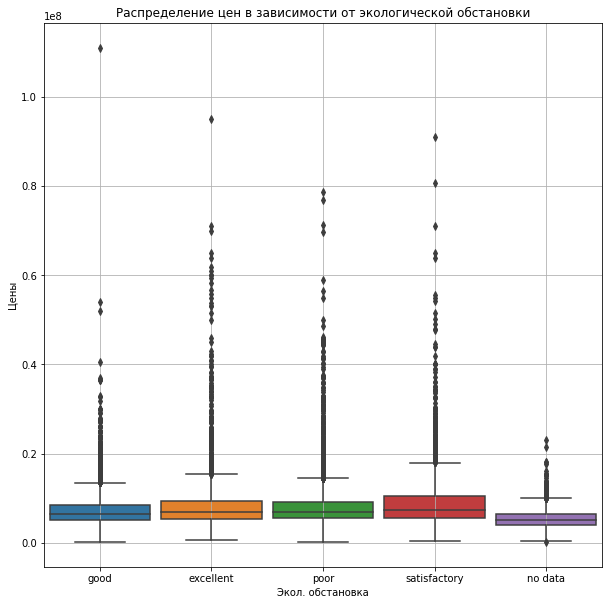

In [8]:
# Проверим, влияет ли уровень экологической обстановки в районе на цену квартиры.
# Постройте коробчатую диаграмму цен на квартиры (price_doc) в зависимости от уровня
# экологической обстановки в районе (ecology). Какой уровень ценится на рынке меньше всего?

fig = plt.figure(figsize=(10, 10))
boxplot = sns.boxplot(
    data=sber_data,
    x='ecology',
    y='price_doc',
    orient='v', # параметр orient отвечает за ориентацию графика h - горизонтальная, v - вертикальная
    width=0.9 # ширина коробок
)
boxplot.set_title('Распределение цен в зависимости от экологической обстановки');
boxplot.set_xlabel('Экол. обстановка');
boxplot.set_ylabel('Цены');
boxplot.grid()

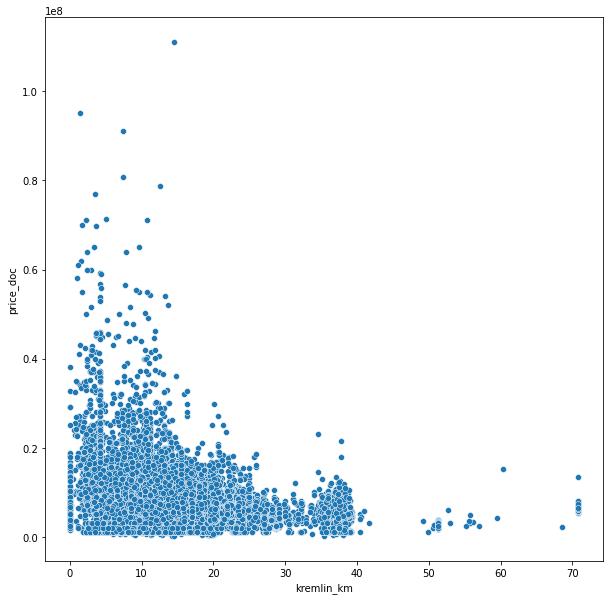

In [13]:
# Постройте диаграмму рассеяния, которая покажет, как цена на квартиру (price_doc)
# связана с расстоянием до центра Москвы (kremlin_km). Выберите все верные утверждения.
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(data=sber_data, x="kremlin_km", y="price_doc");

# **Работа с пропусками: как их обнаружить?**

В pandas пропуски обозначаются специальным символом **NaN** (Not-a-Number — «не число»). 

ПРИЧИНЫ ПОЯВЛЕНИЯ ПРОПУСКОВ В ДАННЫХ:
* Ошибка ввода данных. Как правило, такая ошибка обусловлена человеческим фактором: никто не застрахован от случайного пропуска графы при заполнении данных.
* Ошибка передачи данных. Эта причина на сегодняшний момент возникает довольно редко: с появлением протоколов проверки выгружаемой информации потерять данные при передаче их по сети становится сложнее, но вероятность такого события ненулевая.
* Намеренное сокрытие информации. Одна из самых распространённых причин, особенно в социологических опросах. Дело в том, что пользователи/опрашиваемые/клиенты часто скрывают информацию о себе. Например, люди, занимающие высокие должности, могут быть связаны контрактом о неразглашении своих доходов. 
* Прямое отсутствие информации. Эта причина очень распространена в данных для рекомендательных систем. Представьте, что у нас есть таблицы фильмов и пользователей, которые просматривают их и ставят им оценки. Мы объединяем всю информацию в одну большую сводную таблицу: например, по строкам идут пользователи, а по столбцам — фильмы. Но вот незадача: у нас нет информации о рейтингах фильмов, которые пользователь ещё не посмотрел. В таком случае на пересечении строки с именем пользователя и столбца с названием фильма, который он ещё не смотрел, ставится пропуск. Главное несчастье состоит в том, что 99 % процентов такой таблицы — это сплошной пропуск.
* Мошенничество. Очень острая проблема в финансовой сфере, особенно в банковских данных. Мошенники нередко указывают ложную информацию или не указывают её вовсе.

КАК ОБНАРУЖИТЬ ПРОПУСКИ?

Ранее мы определяли наличие пропусков в данных с помощью метода info(). Но этот метод не позволяет точно локализовать места пропущенных значений, он выводит только число непустых значений и предназначен для определения факта наличия пропусков.

Найти пропуски зачастую довольно просто за исключением тех случаев, когда пропуски скрыты.

В библиотеке pandas специально для этого реализован метод 

[**isnull()**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.isnull.html)

Этот метод возвращает новый DataFrame, в ячейках которого стоят булевы значения True и False. True ставится на месте, где ранее находилось значение NaN.

In [14]:
# Посмотрим на результат работы метода на нашей таблице
display(sber_data.isnull().tail())

,id,full_sq,life_sq,floor,sub_area,preschool_quota,preschool_education_centers_raion,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,...,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,theater_km,museum_km,ecology,mosque_count_1000,price_doc
30466,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
30467,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
30468,False,False,True,False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
30469,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
30470,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


##### **СПИСОК СТОЛБЦОВ С ПРОПУСКАМИ**
***

Первый способ — это вывести на экран названия столбцов, где число пропусков больше 0.

In [15]:
# Для этого вычислим средний по столбцам результат метода isnull(). Получим долю пропусков в каждом столбце.
# Умножаем на 100 %, находим столбцы, где доля пропусков больше 0, сортируем по убыванию и выводим результат
cols_null_percent = sber_data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

hospital_beds_raion          47.392603
preschool_quota              21.948738
school_quota                 21.938893
life_sq                      20.947786
floor                         0.548062
metro_min_walk                0.082045
metro_km_walk                 0.082045
railroad_station_walk_km      0.082045
railroad_station_walk_min     0.082045
dtype: float64

Итак, можно увидеть, что у нас большое число пропусков (более 47 %) в столбце hospital_beds_raion (количество больничных коек в округе). 

Далее у нас идут столбцы с числом пропусков чуть больше 20 %: 

* preschool_quota (число мест в детском саду в районе);
* school_quota (число мест в школах в районе);
* life_sq (жилая площадь здания в квадратных метрах). 

Менее одного процента пропусков содержат признаки:

* floor (число этажей в доме);
* metro_min_walk (время от дома до ближайшего метро пешком в минутах);
* metro_km_walk (расстояние до ближайшего метро в километрах);
* railroad_station_walk_km (расстояние до ближайшей ж. д. станции в километрах);
* railroad_station_walk_min (время до ближайшей ж. д. станции пешком в минутах).

Эти соотношения дают базовое понимание, какие дальнейшие преобразования со столбцами предстоит производить. Например, уже сейчас ясно, что столбец, в котором почти половина данных пропущена, не может дать нам полезной информации при прогнозировании. Если мы попытаемся его как-то исправить, мы можем только навредить и «нафантазировать» лишнего, поэтому от него, возможно, стоит избавиться. А вот столбцы с менее 1 % пропусков легко можно скорректировать: заполнить отсутствующие значения какими-то числами.

##### **СТОЛБЧАТАЯ ДИАГРАММА ПРОПУСКОВ**
***

Иногда столбцов с пропусками становится слишком много и прочитать информацию о них из списка признаков с цифрами становится слишком затруднительно — цифры начинают сливаться воедино.

Можно воспользоваться столбчатой диаграммой, чтобы визуально оценить соотношение числа пропусков к числу записей. Самый быстрый способ построить её — использовать метод **plot():**

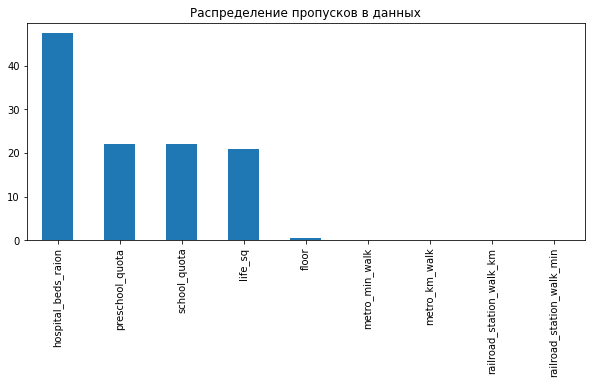

In [16]:
cols_with_null.plot(
    kind='bar',
    figsize=(10, 4),
    title='Распределение пропусков в данных'
);

На диаграмме мы видим те же соотношения, что и раньше, но представленные в удобном для визуального восприятия формате. Из неё отчётливо видно, что число пропусков в столбце hospital_beds_raion превышает 45 %. Также мы видим признаки с числом пропусков близ 0

##### **ТЕПЛОВАЯ КАРТА ПРОПУСКОВ**
***

Её часто используют, когда столбцов с пропусками не так много (меньше 10). Она позволяет понять не только соотношение пропусков в данных, но и их характерное местоположение в таблице.

Для создания такой тепловой карты можно воспользоваться результатом метода isnull(). Ячейки таблицы, в которых есть пропуск, будем отмечать жёлтым цветом, а остальные — синим. Для этого создадим собственную палитру цветов тепловой карты с помощью метода

[**color_pallete()**](https://seaborn.pydata.org/generated/seaborn.color_palette.html)

из библиотеки seaborn.

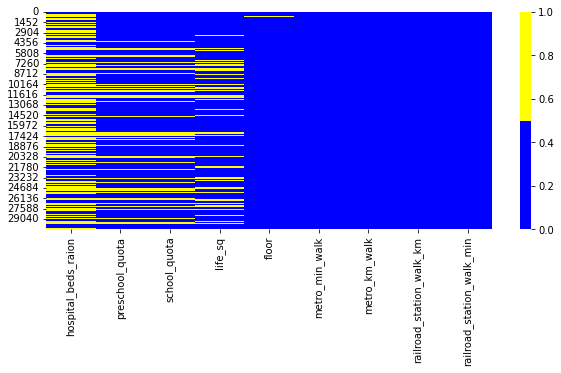

In [17]:
colors = ['blue', 'yellow'] 
fig = plt.figure(figsize=(10, 4))
cols = cols_with_null.index
ax = sns.heatmap(
    sber_data[cols].isnull(),
    cmap=sns.color_palette(colors),
)

На полученной тепловой карте мы не видим чётких процентных соотношений для числа пропусков в данных, однако мы можем увидеть места их концентрации в таблице. Например, видно, что признаки preschool_quota и school_quota очень сильно связаны друг с другом по части пропусков: во всех записях, где хотя бы один не определён, не указан и второй (жёлтые линии для двух этих признаков полностью совпадают друг с другом).